# Learning

We can use the Baum-Welch Algorithm to learn the transition and emission probabilities from a sequence.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import hmm
import itertools
np.random.seed(0)

Let's import our `transition`, `emission` and `init` matrix ready and generate a sequence.

In [2]:
transition = pd.read_csv("cpg_hmm_1/transition.csv",index_col=0)
emission = pd.read_csv("cpg_hmm_1/emission.csv",index_col=0)
init = pd.read_csv("cpg_hmm_1/init.csv",index_col=0)

In [3]:
st, seq = hmm.generate(transition, emission, init, 10)

In [4]:
print(st)
print(seq)

+++++++---
GTGGCTGAGG


## Forward-Backward Algorithm

Before jumping into Baum-Welch, we need to implement the forward-backward algorithm. The forward-backward algorithm can be used to calculate the probability of encountering $\pi_i$ given $x$. This is stored in the `pi_node` matrix ($\Pi^*$).

$$\Pi^*_{i,j} = P(\pi_i|x) = \dfrac{F_{i,j} \times B_{i,j}}{P(x)}$$

where $F$ and $B$ are the forward and backward matrices as defined previously.

Let's obtain the forward and backward matrices for our sequence as well as $P(x)$ given by `P`.

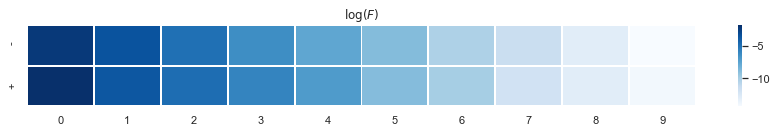

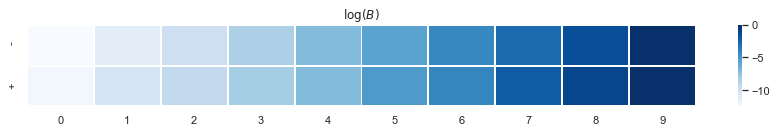

In [5]:
_,F = hmm.forward(seq,transition,emission,init,disp_f=True)
P,B = hmm.backward(seq,transition,emission,init,disp_b=True)

We can now derive $\Pi^*$.

In [6]:
pi_node = B*F/P

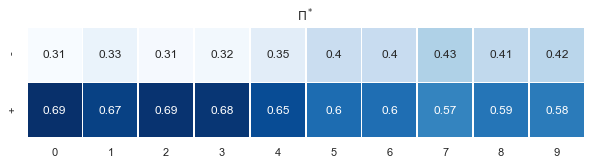

In [7]:
plt.figure(figsize=(10,5))
sns.heatmap(pi_node,square=True,cbar=False,linewidth = 1,cmap='Blues',yticklabels=list(transition.columns),annot=True)
plt.title("$\Pi^*$");

In [8]:
np.sum(pi_node,0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The sum of each column of $\Pi^*$ is 1.

### Probabilities of going through a transition

Just like element-wise multiplication of $F$ and $B$ gives the probabilities of passing through a state, we can also derive the probabilities of going through a transition. This will give us a $k^2 \times (N-1)$ `pi_edge` matrix ($\Pi^{**}$). We can use the $F$ and $B$ matrices to compute $\Pi^{**}$:

$$\Pi^{**}_{\pi_p\rightarrow \pi_q,n} = F_{p,n} \times B_{q,n+1} \times P(\pi_p|\pi_q) \times P(x_{N+1}|\pi_q)$$

where $\pi_p$ and $\pi_q$ are any two possible states and $P(\pi_p|\pi_q)$ is the transition probability of going between them and $P(x_{N+1}|\pi_q)$ is the emission probability of the *N+1*th element in the sequence from the state $\pi_q$.

In [9]:
#constructing matrices
k = np.shape(emission)[0]
N = len(list(seq))
pi_edge = np.zeros([k**2,N-1]) #pi_edge matrix

#fill up step
for n in range(0,N-1):
    for m,x in enumerate(itertools.product(range(k),
                               range(k))):
        pi_edge[m,n] = F[x[0],n]*B[x[1],n+1]*transition.iloc[x[0],x[1]]*emission[seq[n+1]][x[1]]
pi_edge = pi_edge/P

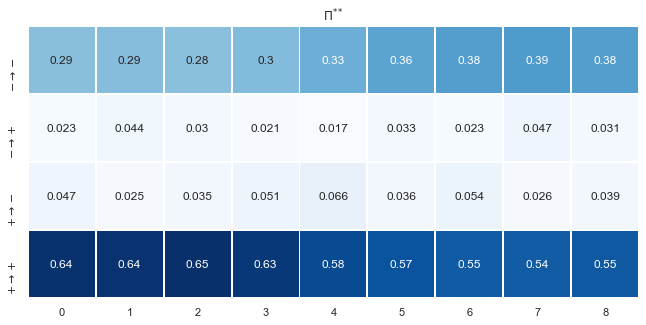

In [10]:
plt.figure(figsize=(11,5))
#transitions
transits = np.array([i for i in itertools.product(list(transition.columns),list(transition.columns))],dtype='object')
transits[:,0] = "$"+transits[:,0]+r"\rightarrow"; transits[:,1] = transits[:,1]+"$"
transits = np.sum(transits,1)

sns.heatmap(pi_edge,square=True,cbar=False,linewidth = 1,
            yticklabels=list(transits),cmap='Blues',annot=True)
plt.title("$\Pi^{**}$");

In [11]:
np.sum(pi_edge,0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

The sum of each column of $\Pi^{**}$ is also 1.

## Examples of running Forward-Backward on other sequences and HMMs

In [12]:
transition_2 = hmm.transition_Durbin_CpG(1/20,1/20)
emission_2 = pd.read_csv("cpg_hmm_2/emission.csv",index_col=0)
init_2 = pd.read_csv("cpg_hmm_2/init.csv",index_col=0)

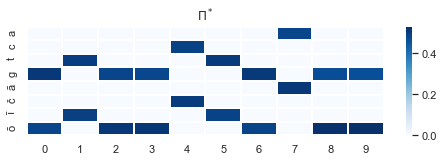

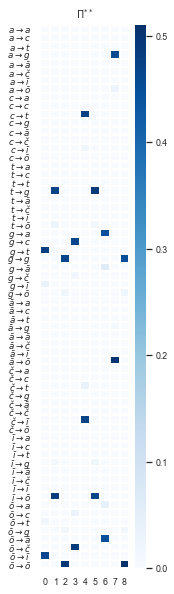

In [13]:
_,_,_ = hmm.forward_backward(seq, transition_2, emission_2, init_2, disp_pn = True, disp_pe = True)

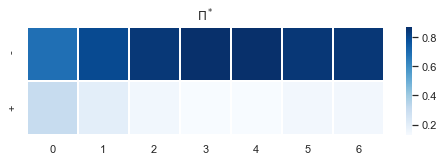

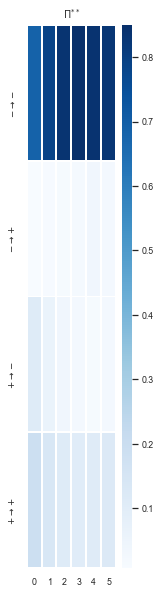

In [14]:
_,_,_ = hmm.forward_backward("GATTACA", transition, emission, init, disp_pn = True, disp_pe = True)

# Baum-Welch Algorithm

The Baum-Welch Algorithm uses the forward-backward algorithms to derive $\Pi^*$ and $\Pi^{**}$. With these two matrices in hand, we can calculate the expected transition and emission probabilities for an HMM given our sequence. Doing this iteratively unto convergence should give us the expected transition and emission probabilities for the most likely HMM given our sequence. This is exactly what learning is!

To get transition and emission matrices from $\Pi^*$ and $\Pi^{**}$:

In [15]:
transition_est = pd.DataFrame(np.sum(pi_edge,1).reshape(k,k), columns = transition.columns, index = transition.index)
#sum over the rows to get 4 values, one for each type of transition

transition_est = transition_est.div(transition_est.sum(axis=1), axis=0) #row normalize

transition_est

,-,+
-,0.917554,0.082446
+,0.066252,0.933748


In [16]:
emission_est = emission.copy(); emission_est.iloc[:,:] = 0
for i,r in enumerate(emission.index):
    for j,c in enumerate(emission.columns):
        emission_est.loc[r,c] = np.sum(pi_node[i][np.array(list(seq),dtype='object')==c])

#row normalize
emission_est = emission_est.div(emission_est.sum(axis=1), axis=0)

emission_est

,A,C,T,G
-,0.117088,0.094783,0.198412,0.589717
+,0.090004,0.103052,0.200929,0.606015


## Learning Emission and Transition Probabilities from a drosophila genome sequence

In [17]:
seq_X = ("GACGAATAACCACAAAGAACTAAAGTTAAACTACCAGCAAAGTTAAAGCTCAAAGCAAGCTACAATATAA"
"ATTAAACAAATAAAATAAACGAATTAAATAAACTAATAATAAAACCTACTTAATAAAATAAACCGCGCTT"
"TCACCTGCATAATTTTCTCACGCGCAAATTTAATTTAAATCGCCTCTTAGTATGAGAAATTAAAAGTTTA")

#drosophila X-chromosome sequence

tr, em = hmm.baum_welch(seq_X,transition_2,emission_2,init_2) #use our current matrices as a guess

P(x|theta): 1.597911108447635e-130
P(x|theta): 1.3229144373904834e-105
P(x|theta): 2.2927740387817715e-104
P(x|theta): 1.283972381135438e-103
P(x|theta): 3.4122917987538726e-103
P(x|theta): 7.056766126680258e-103
P(x|theta): 1.1688687376714801e-102
P(x|theta): 1.6312111339129892e-102
P(x|theta): 2.07076707407062e-102
P(x|theta): 2.5142894062718565e-102
P(x|theta): 3.007940629299756e-102
P(x|theta): 3.615817000902582e-102
P(x|theta): 4.4314347869830136e-102
P(x|theta): 5.585998020309637e-102
P(x|theta): 7.202661180372198e-102
P(x|theta): 9.258549279631931e-102
P(x|theta): 1.1507501474501853e-101
P(x|theta): 1.3633218844683944e-101
P(x|theta): 1.5458321637546632e-101
P(x|theta): 1.6986640357583793e-101
P(x|theta): 1.830741855432276e-101
P(x|theta): 1.950645192072508e-101
P(x|theta): 2.0635529602411538e-101
P(x|theta): 2.1714961304142176e-101
P(x|theta): 2.2744341412834007e-101
P(x|theta): 2.3712550341949244e-101
P(x|theta): 2.4605303636138315e-101
P(x|theta): 2.5410245408846978e-101
P(x|

In [18]:
em

,A,C,T,G
a,1.0,0.0,0.0,0.0
c,0.0,1.0,0.0,0.0
t,0.0,0.0,1.0,0.0
g,0.0,0.0,0.0,1.0
ā,1.0,0.0,0.0,0.0
č,0.0,1.0,0.0,0.0
ī,0.0,0.0,1.0,0.0
ō,0.0,0.0,0.0,1.0


In [19]:
tr

,a,c,t,g,ā,č,ī,ō
a,5.325107e-01,1.096298e-01,1.717892e-01,1.118766e-01,3.341749e-02,5.309636e-11,4.077624e-02,4.348956e-10
c,4.516796e-01,1.473848e-01,3.776945e-01,1.064408e-22,1.447168e-16,2.323840e-02,6.149663e-12,2.666164e-06
t,6.897183e-01,2.561547e-02,2.846619e-01,8.161207e-09,8.545081e-14,1.593843e-06,2.686363e-06,2.487124e-121
g,2.500001e-01,4.166666e-01,3.333333e-01,0.000000e+00,8.671526e-11,2.047145e-10,9.601411e-28,0.000000e+00
ā,4.591360e-01,1.576094e-18,1.752349e-20,1.474514e-21,8.145359e-12,5.408640e-01,7.374621e-25,5.936231e-26
č,4.290611e-16,9.699627e-34,2.260466e-10,6.853806e-17,1.965073e-01,1.536704e-01,2.707606e-01,3.790617e-01
ī,4.324469e-06,2.737274e-12,1.189301e-01,1.443660e-01,1.848140e-29,3.607120e-01,3.759876e-01,4.828550e-123
ō,3.546174e-06,9.457329e-10,0.000000e+00,0.000000e+00,3.749964e-01,6.250001e-01,0.000000e+00,0.000000e+00


Note that a large sequence will quickly run into overflow errors while running the forward-backward algorithm.